In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = pd.read_parquet('gt2011-gt2015.parquet')

In [3]:
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,Datetime
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,2011-01-01 00:00:00
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,2011-01-01 01:10:55
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,2011-01-01 02:21:50
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,2011-01-01 03:32:45
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,2011-01-01 04:43:40
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,2015-12-31 18:21:49
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,2015-12-31 19:33:00
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,2015-12-31 20:44:11
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,2015-12-31 21:55:22


In [5]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


<AxesSubplot:xlabel='NOX', ylabel='Count'>

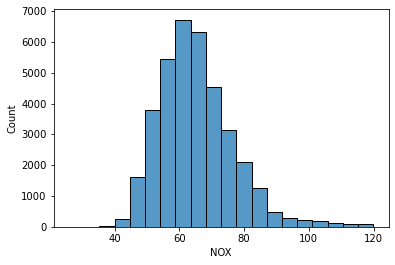

In [6]:
sns.histplot(df, x='NOX', bins=20)

<AxesSubplot:xlabel='CO', ylabel='Count'>

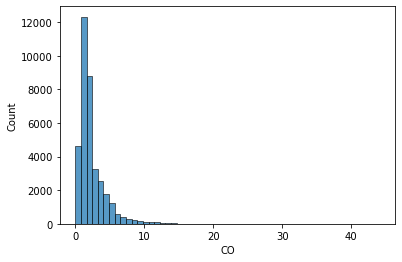

In [7]:
sns.histplot(df, x='CO', bins=54)

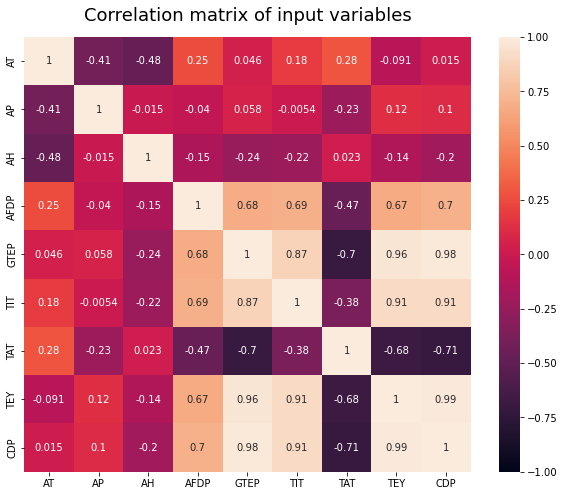

In [8]:

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(df.drop(columns=['CO','NOX']).corr()))

heatmap = sns.heatmap(df.drop(columns=['CO','NOX']).corr(),  vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation matrix of input variables', fontdict={'fontsize':18}, pad=16);

In [9]:
CO_list = []
NOX_list = []

for column in df.columns[:-2]:
    CO_list.append(df['CO'].corr(df[column]))
    NOX_list.append(df['NOX'].corr(df[column]))
corr_df = pd.DataFrame({'CO': CO_list, 'NOX': NOX_list},index=df.columns[:-2])    


cm = sns.light_palette("green", as_cmap=True)

display(((corr_df).round(3)).style.background_gradient(cmap="PiYG",axis=None).format("{:3}"))

,CO,NOX
AT,-0.174,-0.558
AP,0.067,0.192
AH,0.107,0.165
AFDP,-0.448,-0.188
GTEP,-0.519,-0.202
TIT,-0.706,-0.214
TAT,0.058,-0.093
TEY,-0.57,-0.116
CDP,-0.551,-0.171
CO,1.0,0.341


# Prediction

In [10]:
# df = df.drop(df[df['Datetime'].dt.year > 2012].index)

In [11]:
train_data = df[df['Datetime'].dt.year.isin([2011, 2012, 2013])]
X_train, y_train = train_data[[cols]], train_data['NOX']
test_data = df[df['Datetime'].dt.year.isin([2014, 2015])]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,Datetime
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,2011-01-01 00:00:00
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,2011-01-01 01:10:55
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,2011-01-01 02:21:50
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,2011-01-01 03:32:45
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,2011-01-01 04:43:40
...,...,...,...,...,...,...,...,...,...,...,...,...
15034,10.0370,1022.1,88.531,2.9192,23.641,1083.6,549.91,132.61,11.745,1.65600,76.068,2012-12-31 19:09:18
15035,9.8921,1022.2,87.622,2.9415,23.859,1084.9,550.08,133.57,11.869,1.55490,74.930,2012-12-31 20:18:24
15036,9.8723,1022.0,86.618,2.9309,23.817,1084.8,549.99,133.50,11.914,1.40930,75.041,2012-12-31 21:27:30
15037,10.0260,1022.0,87.301,2.9363,23.831,1084.5,550.01,133.20,11.811,1.39630,74.460,2012-12-31 22:36:36


In [12]:

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
X = df.drop(columns=['CO','NOX'], axis=1)

In [14]:
# X = df[df.columns[:-2]]

X = df[['GTEP','TIT','TEY','CDP']]

y = df['CO']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.65,random_state=42
)

In [15]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:2.22878	validation_1-rmse:2.01027
[1]	validation_0-rmse:1.92533	validation_1-rmse:1.68562
[2]	validation_0-rmse:1.76101	validation_1-rmse:1.51133
[3]	validation_0-rmse:1.68582	validation_1-rmse:1.43197
[4]	validation_0-rmse:1.64717	validation_1-rmse:1.39282
[5]	validation_0-rmse:1.61292	validation_1-rmse:1.36425
[6]	validation_0-rmse:1.59466	validation_1-rmse:1.34979
[7]	validation_0-rmse:1.58618	validation_1-rmse:1.34487
[8]	validation_0-rmse:1.58040	validation_1-rmse:1.34177
[9]	validation_0-rmse:1.57679	validation_1-rmse:1.34097
[10]	validation_0-rmse:1.57355	validation_1-rmse:1.33947
[11]	validation_0-rmse:1.56224	validation_1-rmse:1.33734
[12]	validation_0-rmse:1.55634	validation_1-rmse:1.33655
[13]	validation_0-rmse:1.55301	validation_1-rmse:1.33685
[14]	validation_0-rmse:1.54426	validation_1-rmse:1.33273
[15]	validation_0-rmse:1.53682	validation_1-rmse:1.33291
[16]	validation_0-rmse:1.53286	validation_1-rmse:1.32870
[17]	validation_0-rmse:1.52207	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

0.6943621022132143

In [17]:
X_test

,GTEP,TIT,TEY,CDP
13312,25.581,1091.0,135.11,12.123
12627,25.882,1091.7,134.20,12.160
6393,23.057,1080.4,128.14,11.693
4990,20.005,1060.0,112.05,10.732
12462,25.295,1090.1,133.59,12.010
...,...,...,...,...
11140,26.073,1092.3,133.81,12.324
10579,26.905,1097.5,136.95,12.316
10098,30.977,1100.4,154.90,13.688
7862,23.548,1082.8,134.97,11.749


In [18]:
from sklearn.metrics import mean_absolute_error
# Mean absolute error
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

0.5975986480139726

In [19]:
#Defining MAPE function
def mape_fun(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [20]:
mape_fun(y_test,preds)

121.03513147768635

In [21]:
X = df[['AT']]

y = df['NOX']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.65,random_state=42
)



from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="mape", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-mape:0.69129	validation_1-mape:0.69156
[1]	validation_0-mape:0.48006	validation_1-mape:0.48055
[2]	validation_0-mape:0.33256	validation_1-mape:0.33329
[3]	validation_0-mape:0.22988	validation_1-mape:0.23055
[4]	validation_0-mape:0.16279	validation_1-mape:0.16315
[5]	validation_0-mape:0.12365	validation_1-mape:0.12358
[6]	validation_0-mape:0.10365	validation_1-mape:0.10331
[7]	validation_0-mape:0.09425	validation_1-mape:0.09372
[8]	validation_0-mape:0.08983	validation_1-mape:0.08922
[9]	validation_0-mape:0.08775	validation_1-mape:0.08732
[10]	validation_0-mape:0.08677	validation_1-mape:0.08656
[11]	validation_0-mape:0.08640	validation_1-mape:0.08629
[12]	validation_0-mape:0.08628	validation_1-mape:0.08627
[13]	validation_0-mape:0.08631	validation_1-mape:0.08633
[14]	validation_0-mape:0.08634	validation_1-mape:0.08642
[15]	validation_0-mape:0.08635	validation_1-mape:0.08650
[16]	validation_0-mape:0.08636	validation_1-mape:0.08652
[17]	validation_0-mape:0.08641	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [22]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

0.39952017949204055

In [23]:
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

5.929144331305397

In [24]:
mape_fun(y_test,preds)

8.664392555697313

# TODO_a

In [25]:
df_train = X_train.join(y_train)
df_train['preds'] = reg.predict(X_train)
df_train['y_train'] = y_train
df_train['diff'] = np.abs(df_train['preds'] - df_train['y_train'])
delta_m = (df_train['diff'].sum())/len(df_train)
df_train['deltas_diff'] = (df_train['diff'] - delta_m)**2
u_train = np.sqrt(df_train['deltas_diff'].sum()/(len(df_train)-1))
u_train

5.32984256081025

In [26]:
df_test = X_test.join(y_test)
df_test['preds'] = reg.predict(X_test)
df_test['y_test'] = y_test
df_test['diff'] = np.abs(df_test['preds'] - df_test['y_test'])
delta_m = (df_test['diff'].sum())/len(df_test)
df_test['deltas_diff'] = (df_test['diff'] - delta_m)**2
u_test = np.sqrt(df_test['deltas_diff'].sum()/(len(df_test)-1))
u_test

5.57476333355846

In [27]:
u_test = np.sqrt(df_test['deltas_diff'].sum()/(len(df_test-1)))
u_test

5.574233790614159

In [28]:
u_pems = np.sqrt(u_train**2 + u_test**2)
u_pems

7.712282676059601

In [29]:
c_pems = df_train['NOX'].max() - df_train['NOX'].min()
c_pems

78.113

In [30]:
U_pems = 1.96*u_pems/c_pems
U_pems

0.1935154717534446

# TODO_b

In [31]:
import numpy as np 
from scipy.stats import t

In [32]:
x = df[['NOX']]
m = x.mean() 
s = x.std() 
dof = len(x)-1 
confidence = 0.95

In [33]:
dof

15038

In [34]:
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

In [35]:
t_crit

1.960121748799443

In [36]:
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x))) 

(NOX    68.023577
 dtype: float64,
 NOX    68.358291
 dtype: float64)

In [37]:
s*t_crit/np.sqrt(len(x))

NOX    0.167357
dtype: float64